# Exam Project | Face Recognizer
By **Pernille Lørup & Stephan Djurhuus**  
Institute **CPHBusiness**  

Education **Software Development**  
Elective **Artificial Intelligence**  

## The Content
## The Theory
## The Source

In [1]:
import sys
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy

sys.path.append('../')
from FaceDetector import FaceDetector
from DataGenerator import DataGenerator

In [2]:
dad_path = '../data/face-data/PersonGroup/Family1-Dad'
mom_path = '../data/face-data/PersonGroup/Family1-Mom'

train_dad_data = DataGenerator.generate(dad_path, 10, label=0)
train_mom_data = DataGenerator.generate(mom_path, 10, label=1)
(train_images, train_labels), (test_images, test_labels) = DataGenerator.merge_shuffle([train_dad_data, train_mom_data], 0.2)

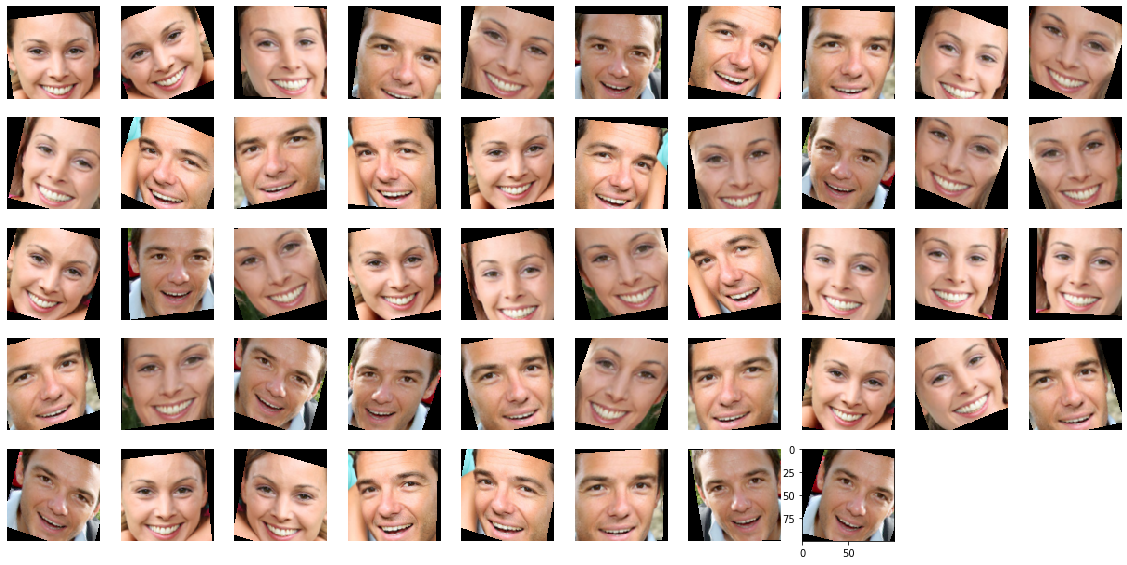

In [19]:
plt.figure(figsize=(20,20))

for index, train_image in enumerate(train_images):
    plt.axis("off")
    train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(10, 10, 1+index)
    plt.imshow(train_image)

plt.show()

In [4]:
model = models.Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(2)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 21, 21, 64)        36928     
_________________________________________________________________
flatten (Flatten)            (None, 28224)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                1

In [5]:
loss_func = SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam', loss=loss_func, metrics=['accuracy'])

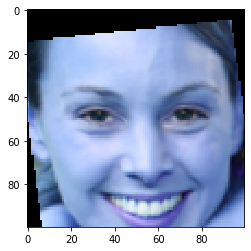

train images shape (48, 100, 100, 3)
test images shape (12, 100, 100, 3) 

Train on 48 samples, validate on 12 samples
Epoch 1/10
48/48 [==============================] - 3s 69ms/sample - loss: 0.9540 - accuracy: 0.4792 - val_loss: 0.6816 - val_accuracy: 0.5833
Epoch 2/10
48/48 [==============================] - 1s 16ms/sample - loss: 0.7202 - accuracy: 0.4792 - val_loss: 0.6810 - val_accuracy: 0.5833
Epoch 3/10
48/48 [==============================] - 1s 14ms/sample - loss: 0.7092 - accuracy: 0.4792 - val_loss: 0.7304 - val_accuracy: 0.4167
Epoch 4/10
48/48 [==============================] - 1s 14ms/sample - loss: 0.6708 - accuracy: 0.6042 - val_loss: 0.7107 - val_accuracy: 0.4167
Epoch 5/10
48/48 [==============================] - 1s 14ms/sample - loss: 0.6311 - accuracy: 0.5417 - val_loss: 0.6611 - val_accuracy: 0.5833
Epoch 6/10
48/48 [==============================] - 1s 15ms/sample - loss: 0.6344 - accuracy: 0.6667 - val_loss: 0.7236 - val_accuracy: 0.5833
Epoch 7/10
48/48 [=====

In [6]:
train_images = np.array([image/255 for image in train_images], dtype=np.float32)
train_images = np.asarray(train_images)

test_images = np.array([image/255 for image in test_images], dtype=np.float32)
test_images = np.asarray(test_images)

train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

print('train images shape', train_images.shape)
print('test images shape', test_images.shape, '\n')

history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels))

12/1 - 0s - loss: 0.7092 - accuracy: 0.5833


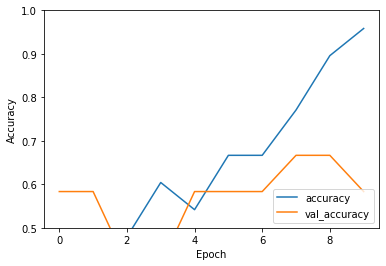

In [7]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

In [8]:
# model.save('models/sequential_model.h5')
# model = tf.keras.models.load_model('models/sequential_model.h5')

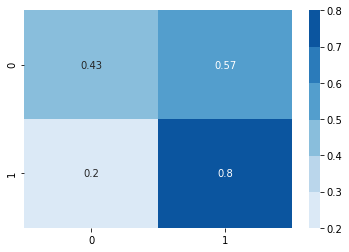

In [9]:
# ...
numpy_test_images = np.array(test_images, dtype='float32')
y_pred = model.predict_classes(numpy_test_images)
conf_matrix = tf.math.confusion_matrix(labels=test_labels, predictions=y_pred).numpy()

# displaying
conf_matrix = np.around([row/sum(row) for row in conf_matrix], decimals=2)
plot = sns.heatmap(conf_matrix, cmap=sns.color_palette("Blues"), annot=True)
figure = plot.get_figure()

predictions [[-0.41771272  0.6999614 ]]
prediction mom


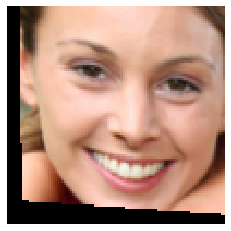

In [47]:
image_index = 9
classes = ['dad', 'mom']
image = np.array([test_images[image_index]], dtype='float32')

predictions = model.predict(image)
prediction = np.argmax(predictions)

print('predictions', predictions)
print('prediction', classes[prediction])

plt.axis("off")
image = cv2.cvtColor(test_images[image_index], cv2.COLOR_BGR2RGB)
plt.imshow(image) 
plt.show()